# Welcome to Day 4

In [ ]:
import os
from os import path
import shutil
import time
import copy
import numpy as np
import pandas as pd

#Import PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models

#Import Matplotlib
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

# Data Loading and Preprocessing


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd '/content/drive/MyDrive/Colab Notebooks/workshop'

##### Unzip

Dataset link: [link](
https://drive.google.com/file/d/1CLqe8c3EWdlt2zBxRSuCdEXwVHqYjYuO/view?usp=drivesdk)



In [ ]:
# !unzip ./NUMTA.zip -d ./NUMTA

In [ ]:
# Hyperparameters
batch_size = 512
num_iters = 3200
input_shape = 28*28 # num_features = 784
output_shape = 10
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
PATH = './NUMTA/'
TRAIN_PATH = './NUMTA/training-a/'
TEST_PATH = './NUMTA/testing-all-corrected/testing-a/'
# os.listdir(PATH)

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
df = pd.read_csv(PATH + "training-a.csv")[['filename', 'digit']]
df.head()

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0


In [ ]:
mean = [0.5,]
std = [0.5, ]

transform = test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

In [ ]:
dataset = Dataset(df, TRAIN_PATH, transform)

In [ ]:
len(dataset)

19702

## Data Splitting

Training Set, Validation Set, Testing Set

In [ ]:
# split data 20% for validation
val_size = 0.2

# obtain training indices that will be used for validation
dataset_size = len(dataset)

# mix data
# indices of all data
indices = list(range(dataset_size))

# random the index
np.random.shuffle(indices)

split = int(np.floor(val_size * dataset_size))

# divied into two part
train_idx, val_idx = indices[split:], indices[:split]

In [ ]:
# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

print("Train Samples: ",len(train_idx))
print("Validation Samples: ",len(val_idx))

Train Samples:  15762
Validation Samples:  3940


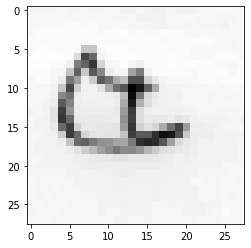

In [ ]:
show_img = dataset[0][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')

In [ ]:
dataset[0][1]

5

## Dataloader

In [ ]:
'''
MAKING DATASET ITERABLE
'''

# prepare loaders
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=train_sampler, num_workers=4)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=4)

In [ ]:
image, label = next(iter(val_loader))
image.shape, label.shape

(torch.Size([812, 1, 28, 28]), torch.Size([812]))

In [ ]:
# torch.flatten(image,1,3).shape
# image.view(image.shape[0], -1).shape

# FCN Model

In [ ]:
class FC(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)    #Input Layer
        self.fc2 = nn.Linear(512, 256)          #Hidden Layer
        self.fc3 = nn.Linear(256, 128)          #Hidden Layer
        self.fc4 = nn.Linear(128, num_classes)   #Output Layer

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        # probas = F.log_softmax(self.fc4(x), dim=1)
        logits = self.fc4(x)
        
        return logits

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''

model = FC(input_size=input_shape, num_classes=output_shape)

# To enable GPU
model.to(device)

FC(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
optimizer1 = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion1 = nn.CrossEntropyLoss()

## Batch Size, Epochs, Iterations

In [ ]:
num_batches = (len(train_idx) / batch_size)
num_epochs = num_iters / num_batches
num_epochs = int(num_epochs)

print(f'Total Epochs: {num_epochs}')

Total Epochs: 103


# ConvNets

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # input_shape = 1X28X28
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        self.conv1 = nn.Conv2d(1, 10, 5) #output: 10X24X24
        #torch.nn.MaxPool2d(kernel_size, stride=None)
        self.pool1 = nn.MaxPool2d(2, 2) #output: 10X12X12
        self.conv2 = nn.Conv2d(10, 20, 5) #output: 20X8X8
        self.pool2 = nn.MaxPool2d(2, 2) #output: 20X4X4
        self.fc1 = nn.Linear(20 * 4 * 4, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''

model2 = ConvNet(num_classes=output_shape)

# To enable GPU
model2.to(device)

# INSTANTIATE OPTIMIZER CLASS
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)
criterion2 = nn.CrossEntropyLoss().to(device)

ConvNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
num_batches = (len(train_idx) / batch_size)
num_epochs = num_iters / num_batches
num_epochs = int(num_epochs)

print(f'Total Epochs: {num_epochs}')

Total Epochs: 103


In [ ]:
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_idx), 'val': len(val_idx)}

# Training

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    all_train_loss = []
    all_val_loss = []
    all_train_acc = []
    all_val_acc = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(0, num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              all_train_loss.append(epoch_loss)
              all_train_acc.append(epoch_acc)
            elif phase == 'val':
              all_val_loss.append(epoch_loss)
              all_val_acc.append(epoch_acc)              

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # plotting the training and validation loss
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(all_train_loss, label='Training loss')
    axs[0].plot(all_val_loss, label='Validation loss')
    axs[0].set_label("Training VS. Validation Loss")
    axs[0].set(xlabel="Epochs", ylabel="Loss")
    # plotting the training and validation accuracy
    axs[1].plot(all_train_acc, label='Training accuracyc')
    axs[1].plot(all_val_acc, label='Validation accuracy')
    axs[1].set_label("Training VS. Validation Accuracy")
    axs[1].set(xlabel="Epochs", ylabel="Accuracy")

    axs[0].legend()
    axs[1].legend()

    # fig.tight_layout()
    plt.show()    
    return model

### Training FCN

Epoch 1/50
----------
train Loss: 1.8319 Acc: 0.3703
val Loss: 1.7906 Acc: 0.3624

Epoch 2/50
----------
train Loss: 1.7515 Acc: 0.3996
val Loss: 1.6710 Acc: 0.4434

Epoch 3/50
----------
train Loss: 1.6534 Acc: 0.4425
val Loss: 1.6157 Acc: 0.4487

Epoch 4/50
----------
train Loss: 1.6484 Acc: 0.4314
val Loss: 1.6194 Acc: 0.4470

Epoch 5/50
----------
train Loss: 1.5063 Acc: 0.5010
val Loss: 1.4581 Acc: 0.5216

Epoch 6/50
----------
train Loss: 1.4966 Acc: 0.4973
val Loss: 1.4435 Acc: 0.5226

Epoch 7/50
----------
train Loss: 1.4056 Acc: 0.5324
val Loss: 1.4306 Acc: 0.5071

Epoch 8/50
----------
train Loss: 1.3653 Acc: 0.5449
val Loss: 1.2868 Acc: 0.5756

Epoch 9/50
----------
train Loss: 1.4052 Acc: 0.5312
val Loss: 1.4903 Acc: 0.4561

Epoch 10/50
----------
train Loss: 1.4661 Acc: 0.4991
val Loss: 1.2743 Acc: 0.5871

Epoch 11/50
----------
train Loss: 1.2570 Acc: 0.5886
val Loss: 1.2281 Acc: 0.5980

Epoch 12/50
----------
train Loss: 1.1977 Acc: 0.6088
val Loss: 1.2134 Acc: 0.5919

E

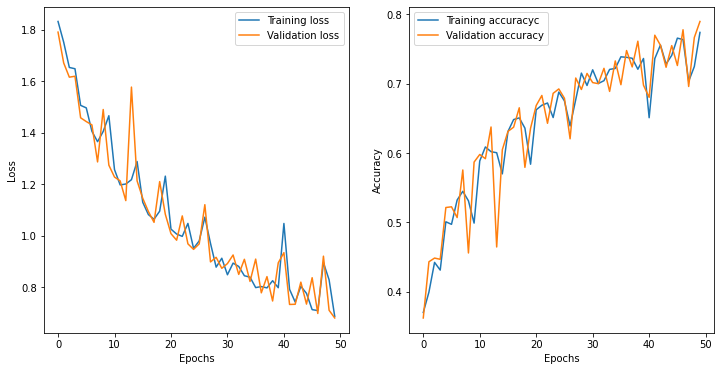

In [ ]:
model = train_model(model, criterion1 , optimizer1, num_epochs=50)#num_epochs)

### Training ConvNet

Epoch 1/50
----------
train Loss: 2.2994 Acc: 0.1209
val Loss: 2.2825 Acc: 0.1655

Epoch 2/50
----------
train Loss: 2.1715 Acc: 0.2193
val Loss: 1.9856 Acc: 0.3256

Epoch 3/50
----------
train Loss: 1.7947 Acc: 0.3699
val Loss: 1.6801 Acc: 0.3893

Epoch 4/50
----------
train Loss: 1.5210 Acc: 0.4588
val Loss: 1.6082 Acc: 0.4218

Epoch 5/50
----------
train Loss: 1.3805 Acc: 0.5080
val Loss: 1.3019 Acc: 0.5378

Epoch 6/50
----------
train Loss: 1.2356 Acc: 0.5648
val Loss: 1.2169 Acc: 0.5472

Epoch 7/50
----------
train Loss: 1.1198 Acc: 0.5983
val Loss: 1.0958 Acc: 0.6071

Epoch 8/50
----------
train Loss: 1.0439 Acc: 0.6214
val Loss: 1.0031 Acc: 0.6444

Epoch 9/50
----------
train Loss: 0.9528 Acc: 0.6622
val Loss: 0.9367 Acc: 0.6657

Epoch 10/50
----------
train Loss: 0.8758 Acc: 0.6903
val Loss: 0.8865 Acc: 0.6739

Epoch 11/50
----------
train Loss: 0.8566 Acc: 0.6913
val Loss: 0.8798 Acc: 0.6711

Epoch 12/50
----------
train Loss: 0.7777 Acc: 0.7259
val Loss: 0.7714 Acc: 0.7274

E

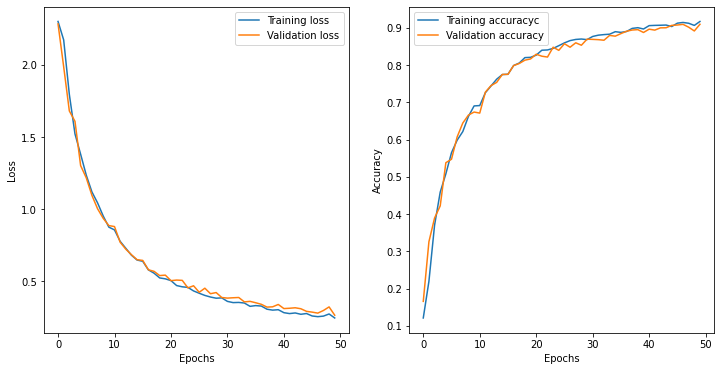

In [ ]:
model2 = train_model(model2, criterion2, optimizer2, num_epochs=50)#num_epochs)

## Evaluating Classwise Performance

In [ ]:
classes = np.arange(0,10)

## FCN

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 78.95939086294416 %
Accuracy of 0: 71.21588089330025 %
Accuracy of 1: 62.06896551724138 %
Accuracy of 2: 78.78048780487805 %
Accuracy of 3: 85.96491228070175 %
Accuracy of 4: 96.50872817955113 %
Accuracy of 5: 82.66666666666667 %
Accuracy of 6: 89.62962962962963 %
Accuracy of 7: 84.75452196382429 %
Accuracy of 8: 80.72916666666667 %
Accuracy of 9: 56.64160401002506 %


## ConvNet

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 90.96446700507614 %
Accuracy of 0: 89.08188585607941 %
Accuracy of 1: 82.49336870026525 %
Accuracy of 2: 94.8780487804878 %
Accuracy of 3: 91.47869674185463 %
Accuracy of 4: 95.76059850374065 %
Accuracy of 5: 91.46666666666667 %
Accuracy of 6: 95.30864197530865 %
Accuracy of 7: 97.1576227390181 %
Accuracy of 8: 94.27083333333333 %
Accuracy of 9: 77.44360902255639 %


# Inference

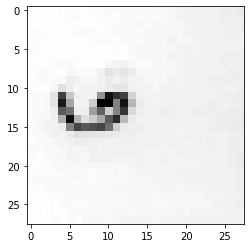

In [ ]:
import glob
i=0
test_images = glob.glob(TEST_PATH+"/*")
img = Image.open(test_images[i]).convert('L')
img = transform(img)
plt.imshow(img.reshape(28,28), cmap='gray')

In [ ]:
prediction = model(img.view(-1, 28*28).to(device))
prediction = torch.argmax(prediction, dim=1)
print('Predicted label', prediction.cpu().numpy())

Predicted label [4]


In [ ]:
prediction2 = model2(img.unsqueeze(0).to(device))
prediction2 = torch.argmax(prediction2, dim=1)
print('Predicted label', prediction2.cpu().numpy())

Predicted label [3]


In [ ]:
# import torch
# import torch.nn as nn

# ''' 3 DIFFERENT METHODS TO REMEMBER:
#  - torch.save(arg, PATH) # can be model, tensor, or dictionary
#  - torch.load(PATH)
#  - torch.load_state_dict(arg)
# '''

# ''' 2 DIFFERENT WAYS OF SAVING
# # 1) lazy way: save whole model
# torch.save(model, PATH)

# # model class must be defined somewhere
# model = torch.load(PATH)
# model.eval()

# # 2) recommended way: save only the state_dict
# torch.save(model.state_dict(), PATH)

# # model must be created again with parameters
# model = Model(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()
# '''



# model = FC(input_shape, output_shape)


# ####################save all ######################################
# for param in model.parameters():
#     print(param)

# # save and load entire model

# FILE = "model.pth"
# torch.save(model, FILE)

# loaded_model = torch.load(FILE)
# loaded_model.eval()

# for param in loaded_model.parameters():
#     print(param)


# ############save only state dict #########################

# # save only state dict
# FILE = "model.pth"
# torch.save(model.state_dict(), FILE)

# print(model.state_dict())
# loaded_model = FC(input_shape, output_shape)
# loaded_model.load_state_dict(torch.load(FILE)) # it takes the loaded dictionary, not the path file itself
# loaded_model.eval()

# print(loaded_model.state_dict())


# ###########save & load checkpoint#####################
# learning_rate = 0.01
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# checkpoint = {
# "epoch": 90,
# "model_state": model.state_dict(),
# "optim_state": optimizer.state_dict()
# }
# print(optimizer.state_dict())
# FILE = "checkpoint.pth"
# torch.save(checkpoint, FILE)

# model = Model(n_input_features=6)
# optimizer = optimizer = torch.optim.SGD(model.parameters(), lr=0)

# checkpoint = torch.load(FILE)
# model.load_state_dict(checkpoint['model_state'])
# optimizer.load_state_dict(checkpoint['optim_state'])
# epoch = checkpoint['epoch']

# model.eval()
# # - or -
# # model.train()

# print(optimizer.state_dict())

# # Remember that you must call model.eval() to set dropout and batch normalization layers 
# # to evaluation mode before running inference. Failing to do this will yield 
# # inconsistent inference results. If you wish to resuming training, 
# # call model.train() to ensure these layers are in training mode.

In [ ]:
""" SAVING ON GPU/CPU 

# 1) Save on GPU, Load on CPU
device = torch.device("cuda")
model.to(device)
torch.save(model.state_dict(), PATH)

device = torch.device('cpu')
model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH, map_location=device))

# 2) Save on GPU, Load on GPU
device = torch.device("cuda")
model.to(device)
torch.save(model.state_dict(), PATH)

model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.to(device)

# Note: Be sure to use the .to(torch.device('cuda')) function 
# on all model inputs, too!

# 3) Save on CPU, Load on GPU
torch.save(model.state_dict(), PATH)

device = torch.device("cuda")
model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH, map_location="cuda:0"))  # Choose whatever GPU device number you want
model.to(device)

# This loads the model to a given GPU device. 
# Next, be sure to call model.to(torch.device('cuda')) to convert the model’s parameter tensors to CUDA tensors
"""

# Train with different loss

## Focal Loss


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps

    def forward(self, inputs, target):
        y = F.one_hot(target, inputs.size(-1))
        logit = F.softmax(inputs, dim=-1)
        logit = logit.clamp(self.eps, 1. - self.eps)

        cross_entropy_loss = -1 * y * torch.log(logit) # cross entropy
        loss = cross_entropy_loss * (1 - logit) ** self.gamma # focal loss

        return loss.sum()

In [ ]:
class AllLoss(nn.Module):
    def __init__(self, loss_type='cross_entropy', num_classes=10):
        super(AllLoss, self).__init__()
        self.loss_type = loss_type
        self.num_classes = num_classes
        if self.loss_type=='cross_entropy':
            self.loss = nn.CrossEntropyLoss().to(device)
        elif self.loss_type=='focal_loss':
            self.loss = FocalLoss(gamma=2, eps=1e-7)
        elif self.loss_type=='hinge_loss':
            self.loss = nn.HingeEmbeddingLoss().to(device)
        elif self.loss_type=='negative_loglikelihood':
            self.loss = nn.NLLLoss().to(device)
    
    def forward(self, inputs, targets):
        if self.loss_type=='cross_entropy':
            return self.loss(inputs, targets)
        elif self.loss_type=='focal_loss':
            return self.loss(inputs, targets)
        elif self.loss_type=='hinge_loss':
            one_hot_labels = F.one_hot(targets, num_classes=self.num_classes)
            return self.loss(inputs, one_hot_labels.float())
        elif self.loss_type=='negative_loglikelihood':
            return self.loss(F.log_softmax(inputs, dim=-1), targets)

In [ ]:
model2 = ConvNet(num_classes=output_shape).to(device)

# INSTANTIATE OPTIMIZER CLASS
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    all_train_loss = []
    all_val_loss = []
    all_train_acc = []
    all_val_acc = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(0, num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              all_train_loss.append(epoch_loss)
              all_train_acc.append(epoch_acc)
            elif phase == 'val':
              all_val_loss.append(epoch_loss)
              all_val_acc.append(epoch_acc)              

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # plotting the training and validation loss
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(all_train_loss, label='Training loss')
    axs[0].plot(all_val_loss, label='Validation loss')
    axs[0].set_label("Training VS. Validation Loss")
    axs[0].set(xlabel="Epochs", ylabel="Loss")
    # plotting the training and validation accuracy
    axs[1].plot(all_train_acc, label='Training accuracyc')
    axs[1].plot(all_val_acc, label='Validation accuracy')
    axs[1].set_label("Training VS. Validation Accuracy")
    axs[1].set(xlabel="Epochs", ylabel="Accuracy")

    axs[0].legend()
    axs[1].legend()

    # fig.tight_layout()
    plt.show()    
    return model

Epoch 1/50
----------
train Loss: 2.2926 Acc: 0.1193
val Loss: 2.2669 Acc: 0.2401

Epoch 2/50
----------
train Loss: 2.1342 Acc: 0.2472
val Loss: 2.0661 Acc: 0.2076

Epoch 3/50
----------
train Loss: 1.8034 Acc: 0.3626
val Loss: 1.6744 Acc: 0.3805

Epoch 4/50
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb9ad9704d0>
Traceback (most recent call last):
  File "/home/shafin/anaconda3/envs/myenv2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/shafin/anaconda3/envs/myenv2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/home/shafin/anaconda3/envs/myenv2/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb9ad9704d0>
Traceback (most recent call last):
  File "/home/shafin/anaconda3/envs/myenv2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/shafin/anaconda3/envs/myenv2/lib/python

train Loss: 1.5842 Acc: 0.4208
val Loss: 1.5683 Acc: 0.4683

Epoch 5/50
----------
train Loss: 1.4502 Acc: 0.4723
val Loss: 1.4050 Acc: 0.5056

Epoch 6/50
----------
train Loss: 1.3176 Acc: 0.5331
val Loss: 1.2847 Acc: 0.5414

Epoch 7/50
----------
train Loss: 1.2378 Acc: 0.5610
val Loss: 1.2317 Acc: 0.5629

Epoch 8/50
----------
train Loss: 1.1694 Acc: 0.5965
val Loss: 1.2421 Acc: 0.5591

Epoch 9/50
----------
train Loss: 1.0849 Acc: 0.6328
val Loss: 1.0380 Acc: 0.6477

Epoch 10/50
----------
train Loss: 0.9965 Acc: 0.6596
val Loss: 0.9759 Acc: 0.6650

Epoch 11/50
----------
train Loss: 0.9219 Acc: 0.6903
val Loss: 0.8935 Acc: 0.7010

Epoch 12/50
----------
train Loss: 0.8696 Acc: 0.7080
val Loss: 0.9096 Acc: 0.7018

Epoch 13/50
----------
train Loss: 0.8146 Acc: 0.7303
val Loss: 0.7926 Acc: 0.7355

Epoch 14/50
----------
train Loss: 0.7524 Acc: 0.7471
val Loss: 0.7717 Acc: 0.7388

Epoch 15/50
----------
train Loss: 0.7167 Acc: 0.7637
val Loss: 0.6952 Acc: 0.7668

Epoch 16/50
--------

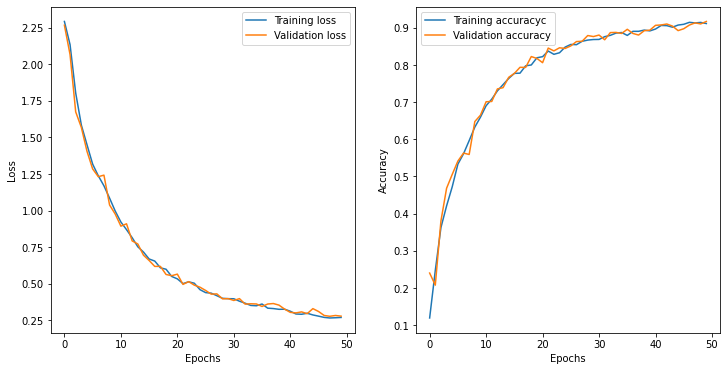

In [ ]:
model_cross_entropy = train_model(model2, 
                                  AllLoss(loss_type='cross_entropy', num_classes=output_shape).to(device), 
                                  optimizer2, num_epochs=50)

Epoch 1/50
----------
train Loss: 1840.6263 Acc: 0.2715
val Loss: 586.2930 Acc: 0.4249

Epoch 2/50
----------
train Loss: 424.6265 Acc: 0.5766
val Loss: 284.3320 Acc: 0.7023

Epoch 3/50
----------
train Loss: 244.4863 Acc: 0.7420
val Loss: 208.2022 Acc: 0.7609

Epoch 4/50
----------
train Loss: 166.2913 Acc: 0.8154
val Loss: 154.6762 Acc: 0.8193

Epoch 5/50
----------
train Loss: 128.3902 Acc: 0.8503
val Loss: 124.3963 Acc: 0.8510

Epoch 6/50
----------
train Loss: 112.4665 Acc: 0.8628
val Loss: 106.7632 Acc: 0.8673

Epoch 7/50
----------
train Loss: 98.2475 Acc: 0.8774
val Loss: 99.8744 Acc: 0.8749

Epoch 8/50
----------
train Loss: 87.3287 Acc: 0.8901
val Loss: 89.7191 Acc: 0.8865

Epoch 9/50
----------
train Loss: 82.2869 Acc: 0.8917
val Loss: 90.1550 Acc: 0.8797

Epoch 10/50
----------
train Loss: 76.0228 Acc: 0.9005
val Loss: 89.4727 Acc: 0.8810

Epoch 11/50
----------
train Loss: 72.4480 Acc: 0.9038
val Loss: 79.2675 Acc: 0.8934

Epoch 12/50
----------
train Loss: 69.2176 Acc: 0.

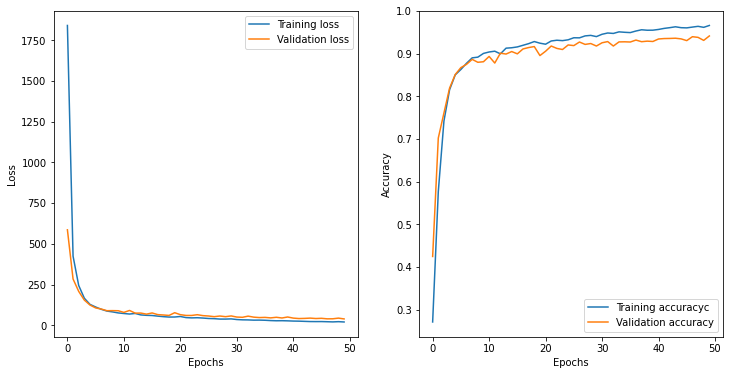

In [ ]:
model_focal = train_model(model2, 
                         AllLoss(loss_type='focal_loss', num_classes=output_shape).to(device), 
                         optimizer2, num_epochs=50)

Epoch 1/50
----------
train Loss: 2.5498 Acc: 0.8716
val Loss: 2.5508 Acc: 0.8386

Epoch 2/50
----------
train Loss: 2.4843 Acc: 0.8771
val Loss: 2.4273 Acc: 0.8931

Epoch 3/50
----------
train Loss: 2.3933 Acc: 0.9236
val Loss: 2.3600 Acc: 0.9135

Epoch 4/50
----------
train Loss: 2.3403 Acc: 0.9385
val Loss: 2.3153 Acc: 0.9183

Epoch 5/50
----------
train Loss: 2.2991 Acc: 0.9418
val Loss: 2.2761 Acc: 0.9188

Epoch 6/50
----------
train Loss: 2.2610 Acc: 0.9426
val Loss: 2.2389 Acc: 0.9190

Epoch 7/50
----------
train Loss: 2.2242 Acc: 0.9425
val Loss: 2.2032 Acc: 0.9201

Epoch 8/50
----------
train Loss: 2.1887 Acc: 0.9411
val Loss: 2.1684 Acc: 0.9188

Epoch 9/50
----------
train Loss: 2.1543 Acc: 0.9403
val Loss: 2.1349 Acc: 0.9160

Epoch 10/50
----------
train Loss: 2.1211 Acc: 0.9381
val Loss: 2.1025 Acc: 0.9132

Epoch 11/50
----------
train Loss: 2.0890 Acc: 0.9363
val Loss: 2.0712 Acc: 0.9124

Epoch 12/50
----------
train Loss: 2.0580 Acc: 0.9345
val Loss: 2.0408 Acc: 0.9114

E

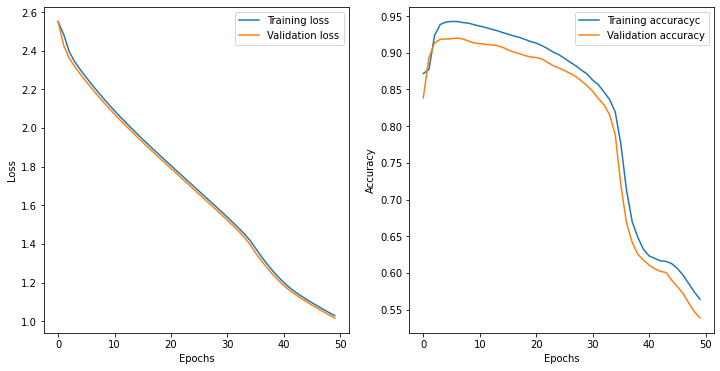

In [ ]:
model_hinge = train_model(model2, 
                         AllLoss(loss_type='hinge_loss', num_classes=output_shape).to(device), 
                         optimizer2, num_epochs=50)

Epoch 1/50
----------
train Loss: 0.2012 Acc: 0.9461
val Loss: 0.2366 Acc: 0.9317

Epoch 2/50
----------
train Loss: 0.1820 Acc: 0.9556
val Loss: 0.2239 Acc: 0.9355

Epoch 3/50
----------
train Loss: 0.1735 Acc: 0.9612
val Loss: 0.2175 Acc: 0.9378

Epoch 4/50
----------
train Loss: 0.1688 Acc: 0.9653
val Loss: 0.2132 Acc: 0.9396

Epoch 5/50
----------
train Loss: 0.1655 Acc: 0.9673
val Loss: 0.2104 Acc: 0.9419

Epoch 6/50
----------
train Loss: 0.1632 Acc: 0.9683
val Loss: 0.2084 Acc: 0.9416

Epoch 7/50
----------
train Loss: 0.1615 Acc: 0.9688
val Loss: 0.2069 Acc: 0.9421

Epoch 8/50
----------
train Loss: 0.1602 Acc: 0.9689
val Loss: 0.2058 Acc: 0.9431

Epoch 9/50
----------
train Loss: 0.1591 Acc: 0.9695
val Loss: 0.2048 Acc: 0.9431

Epoch 10/50
----------
train Loss: 0.1581 Acc: 0.9699
val Loss: 0.2040 Acc: 0.9429

Epoch 11/50
----------
train Loss: 0.1572 Acc: 0.9701
val Loss: 0.2033 Acc: 0.9426

Epoch 12/50
----------
train Loss: 0.1565 Acc: 0.9704
val Loss: 0.2027 Acc: 0.9429

E

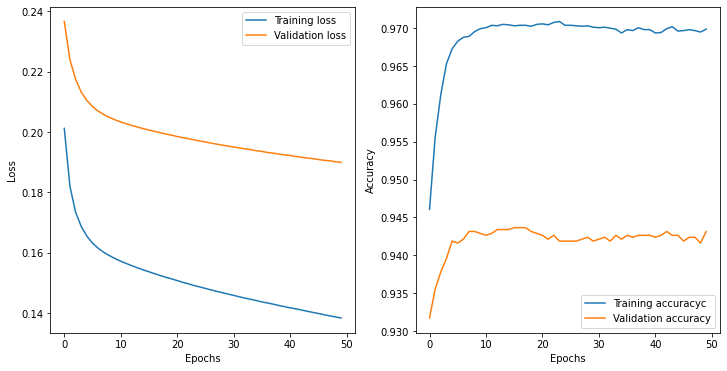

In [ ]:
model_negative_log_likelihood = train_model(model2, 
                         AllLoss(loss_type='negative_loglikelihood', num_classes=output_shape).to(device), 
                         optimizer2, num_epochs=50)

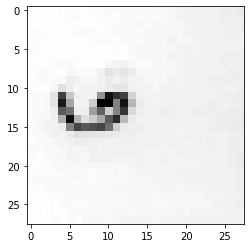

In [ ]:
import glob
i=0
test_images = glob.glob(TEST_PATH+"/*")
img = Image.open(test_images[i]).convert('L')
img = transform(img)
plt.imshow(img.reshape(28,28), cmap='gray')

In [ ]:
prediction2 = model_cross_entropy(img.unsqueeze(0).to(device))
prediction2 = torch.argmax(prediction2, dim=1)
print('Predicted label for cross entropy loss: ', prediction2.cpu().numpy())

prediction2 = model_focal(img.unsqueeze(0).to(device))
prediction2 = torch.argmax(prediction2, dim=1)
print('Predicted label for focal loss: ', prediction2.cpu().numpy())

prediction2 = model_hinge(img.unsqueeze(0).to(device))
prediction2 = torch.argmax(prediction2, dim=1)
print('Predicted label for hinge loss: ', prediction2.cpu().numpy())

prediction2 = model_negative_log_likelihood(img.unsqueeze(0).to(device))
prediction2 = torch.argmax(prediction2, dim=1)
print('Predicted label for negative log likelihood los: ', prediction2.cpu().numpy())

Predicted label for cross entropy loss:  [3]
Predicted label for cfocal loss:  [3]
Predicted label for hinge loss:  [3]
Predicted label for negative log likelihood los:  [3]
